In [323]:
import re, json, requests
from pycoingecko import CoinGeckoAPI
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

## Funções

In [241]:
def utc_to_timestamp(data):
    '''
    Get the date from the format dd/mm/yyyy and convert to timestamp
    '''
    #Get day, month, year
    data = data.split('/')
    day = re.sub('^0','',data[0])
    month = re.sub('^0','',data[1])
    year = data[2]

    #Put into the yyyy/mm/dd format
    date = datetime(int(year), int(month), int(day))

    #Remove decimal part
    
    return '{:.0f}'.format(datetime.timestamp(date))

def get_coingecko_price(coin1, coin2, data_ini, data_end):
    '''
    Download data from the cryptocompare api

    Keyword Arguments:\t
    coin1: Coin to compare price to coin 2\t
    coin2: Coin to compare price to coin 1\t
    data_ini: Initial Date\t
    data_end: Final date
    '''
    cg = CoinGeckoAPI()
    stamp_ini = utc_to_timestamp(data_ini)
    stamp_end = utc_to_timestamp(data_end)
    coin_data = cg.get_coin_market_chart_range_by_id(id=coin1, vs_currency=coin2, from_timestamp=stamp_ini, to_timestamp=stamp_end)
    coin_df = pd.DataFrame(coin_data['prices'], columns=['Datetime','Price'])
    coin_df['Datetime'] = pd.to_datetime(coin_df['Datetime'].astype(int), unit='ms')
    return coin_df
    

def get_cryptocompare_price(coin1, coin2, limit):
    '''
    Download data from the cryptocompare api

    Keyword Arguments:\t
    coin1: Coin to compare price to coin 2\t
    coin2: Coin to compare price to coin 1\t
    limit: Limit of values returned. Maximum of 2000.
    '''  
    endpoint = 'https://min-api.cryptocompare.com/data/histoday'
    res = requests.get(endpoint + '?fsym=' + coin1 + '&tsym=' + coin2 + '&limit=' + limit)
    hist = pd.DataFrame(json.loads(res.content)['Data'])
    hist = hist.set_index('time')
    hist.drop(columns=['conversionType', 'conversionSymbol'], inplace=True ,axis=1)
    hist.index = pd.to_datetime(hist.index, unit='s')
    pair = coin1 + '-' + coin2
    return hist, pair

def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

## Price from CoinGeckoAPI 

In [266]:
df_coingecko = get_coingecko_price(coin1='bitcoin', coin2='usd', data_ini='01/01/2018', data_end = '29/06/2021')
df_coingecko

,Datetime,Price
0,2018-01-02,15321.932852
1,2018-01-03,15583.885538
2,2018-01-04,15976.365194
3,2018-01-05,18336.922980
4,2018-01-06,18343.662493
...,...,...
1270,2021-06-25,34675.449105
1271,2021-06-26,31943.136468
1272,2021-06-27,32023.973902
1273,2021-06-28,34607.293274


## Price from CryptoCompare API

In [476]:
df_cryptocompare, pair = get_cryptocompare_price('ETH','USD','1000')
df_cryptocompare.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2018-10-06,227.29,223.99,228.17,1006198.60,2.264414e+08,225.05
2018-10-07,226.29,223.91,225.05,1071407.41,2.421631e+08,226.02
2018-10-08,230.49,226.24,226.03,1200418.82,2.751695e+08,229.23
2018-10-09,229.53,226.94,229.23,1188808.62,2.706553e+08,227.67
2018-10-10,226.52,224.41,227.67,1200791.37,2.704233e+08,225.20


## Data pre-processing

In [477]:
#Indicate which variable we are using
df_cripto = df_cryptocompare.copy()

#Rename
df_cripto.index.rename("date", inplace=True)

#Get time period
time_period = df_cripto.index.to_list()

#Drop timestamp
#df_cripto.reset_index(drop=True, inplace=True)
df_cripto_dataset = df_cripto.astype(float)

#Feature Scaling
##For all independent variables
scaler = StandardScaler()
df_cripto_scaled = scaler.fit_transform(df_cripto_dataset)

##For the variable to be estimated
scaler_predict = StandardScaler()
scaler_predict.fit_transform(df_cripto_dataset.iloc[:, 0:1])

array([[-0.44791633],
       [-0.44914406],
       [-0.44398761],
       ...,
       [ 2.08090265],
       [ 2.0686254 ],
       [ 1.89826627]])

In [488]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90    # Number of past days we want to use to predict the future

for i in range(n_past, len(df_cripto_scaled) - n_future +1):
    X_train.append(df_cripto_scaled[i - n_past:i, 0:df_cripto_dataset.shape[1]-1])
    y_train.append(df_cripto_scaled[i + n_future - 1:i + n_future, 5])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (852, 90, 5).
y_train shape == (852, 1).


## Model Training

In [489]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df_cripto_dataset.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [490]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    
tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
3/3 [==============================] - 4s 719ms/step - loss: 0.1057 - val_loss: 2.7432

Epoch 00001: val_loss improved from inf to 2.74318, saving model to weights.h5
Epoch 2/30
3/3 [==============================] - 0s 161ms/step - loss: 0.0337 - val_loss: 2.5054

Epoch 00002: val_loss improved from 2.74318 to 2.50543, saving model to weights.h5
Epoch 3/30
3/3 [==============================] - 0s 162ms/step - loss: 0.0241 - val_loss: 2.2402

Epoch 00003: val_loss improved from 2.50543 to 2.24022, saving model to weights.h5
Epoch 4/30
3/3 [==============================] - 0s 161ms/step - loss: 0.0211 - val_loss: 2.1661

Epoch 00004: val_loss improved from 2.24022 to 2.16607, saving model to weights.h5
Epoch 5/30
3/3 [==============================] - 0s 168ms/step - loss: 0.0181 - val_loss: 2.0633

Epoch 00005: val_loss improved from 2.16607 to 2.06331, saving model to weights.h5
Epoch 6/30
3/3 [==============================] - 0s 167ms/step - loss: 0.0172 - val_loss: 1.9

## Make Predictions

In [481]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(time_period[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [482]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [492]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = scaler_predict.inverse_transform(predictions_future)
y_pred_train = scaler_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['close']).set_index(pd.Series(time_period[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,close
2019-06-02,223.843414
2019-06-03,223.822235
2019-06-04,216.603729


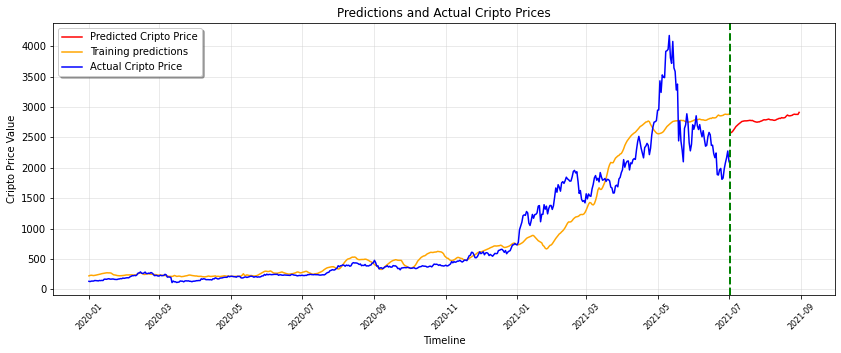

In [494]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['close'], color='r', label='Predicted Cripto Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['close'], color='orange', label='Training predictions')
plt.plot(df_cripto_dataset.loc[START_DATE_FOR_PLOTTING:].index, df_cripto_dataset.loc[START_DATE_FOR_PLOTTING:]['close'], color='b', label='Actual Cripto Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Cripto Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Cripto Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

## Another implementation

## Train and Test split

In [211]:
train, test = train_test_split(price_coin_df, test_size=0.2)

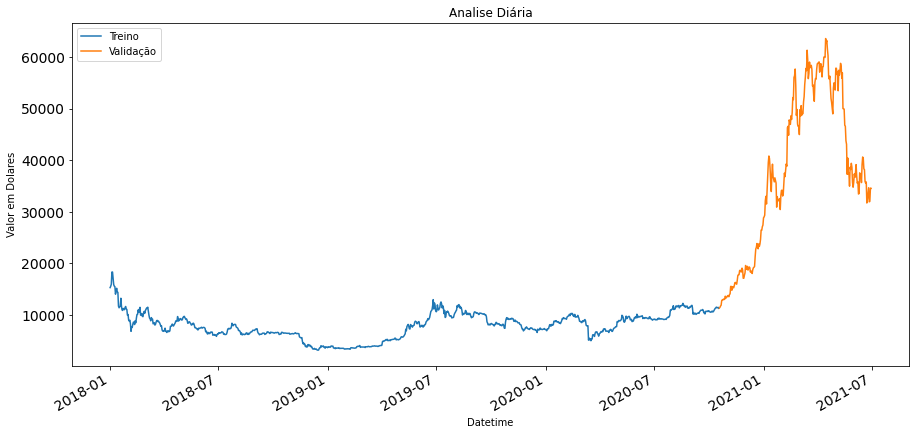

In [212]:
train.Price.plot(figsize = (15,7), title = 'Analise Diária', fontsize =14, label = 'Treino')
test.Price.plot(figsize = (15,7), title = 'Analise Diária', fontsize =14, label = 'Validação')
plt.xlabel('Datetime')
plt.ylabel('Valor em Dolares')
plt.legend(loc = 'best')

In [213]:
# Cria o DataSet para a Celula LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [380]:
def do_lstm_model(df, Y, look_back = 2, Epocas = 2, train_fraction = 0.90):

    # Semente do aleatório fixada
    np.random.seed(7)

    # Seta os dados
    dataset = df[Y].values
    dataset = dataset.astype('float32')

    # Normaliza para facilitar nos calculos,  entre 0 e 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    # Separação entre Treino e Teste
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    Treino, Teste = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # Reshape para X=t e Y=t+1
    look_back = look_back
    TreinoX, TreinoY = create_dataset(Treino, look_back)
    testX, testY = create_dataset(Teste, look_back)
    TreinoX = np.reshape(TreinoX, (TreinoX.shape[0], 1, TreinoX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
    # Chama LSTM e treina a Rede
    batch_size = 1
    model = Sequential()
  
    model.add(LSTM(4, input_shape=(1, look_back)))
  
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(TreinoX, TreinoY, epochs = Epocas, batch_size = 1, verbose = 2)
  
    # Predizer os dados
    trainPredict = model.predict(TreinoX)
    testPredict = model.predict(testX)

    # Volta escapa original para Plotar
    trainPredict = scaler.inverse_transform(trainPredict)
    TreinoY = scaler.inverse_transform([TreinoY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
  
    # Calculo da Raiz do Erro Médio Quadrado (RMSE) e apresenta o resultado
    trainScore = math.sqrt(mean_squared_error(TreinoY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # Criando vetores de train e teste preditos para plotar
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # Código para plotar gráfico de resultados
    plt.figure(figsize=(15, 7))
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    plt.close()

    return

Epoch 1/2
1126/1126 - 3s - loss: 0.0030
Epoch 2/2
1126/1126 - 2s - loss: 3.6638e-04
Train Score: 951.68 RMSE
Test Score: 4024.14 RMSE


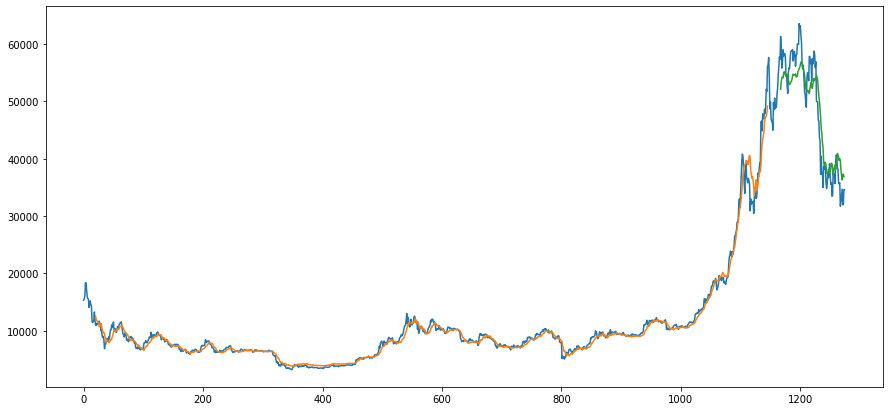

In [381]:
# Lembre-se LoopBack pequeno prevê bem a curto prazo, mas mal a longo prazo
# Por isso o modelo roda em Iterações contínuas de acordo com o tempo e a todo momento
do_lstm_model(df = price_coin_df, Y = 'Price', look_back = 20, Epocas = 2)